In [3]:
from lifelines import KaplanMeierFitter # install
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import linregress
import statsmodels.api as sm

import pymc as pm # install
import arviz as az

import seaborn as sns # install

from sklearn.metrics import mean_squared_error # install

from xarray import open_dataset # To read the trace of an already trained Bayesian model

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'statsmodels'

In [4]:
def estimate_weibull_params(data, time_col='time', event_col='status'):
    # Fit the Kaplan-Meier estimator
    kmf = KaplanMeierFitter()
    kmf.fit(data[time_col], event_observed=data[event_col])

    # Transform the survival function
    time_points = kmf.survival_function_.index
    survival_probs = kmf.survival_function_['KM_estimate']
    log_log_survival = np.log(-np.log(survival_probs))
    log_time = np.log(time_points)

    # Filter out infinite values resulting from log(0)
    valid_idx = np.isfinite(log_log_survival) & np.isfinite(log_time)
    log_log_survival = log_log_survival[valid_idx]
    log_time = log_time[valid_idx]

    # Perform linear regression on the transformed data
    slope, intercept, _, _, _ = linregress(log_time, log_log_survival)

    # Calculate alpha and beta
    alpha = slope
    beta = np.exp(-intercept / alpha)

    # Plot the data and regression line for visualization
    plt.figure(figsize=(10, 6))
    plt.plot(log_time, log_log_survival, 'o')
    plt.plot(log_time, slope * log_time + intercept, 'r-')
    plt.title('Weibull Probability Plot (Log-Log of Survival vs. Log Time)')
    plt.xlabel('log(T)')
    plt.ylabel('log(-log(S(t)))')
    plt.grid(True)
    plt.legend()
    plt.show()

    return alpha, beta

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


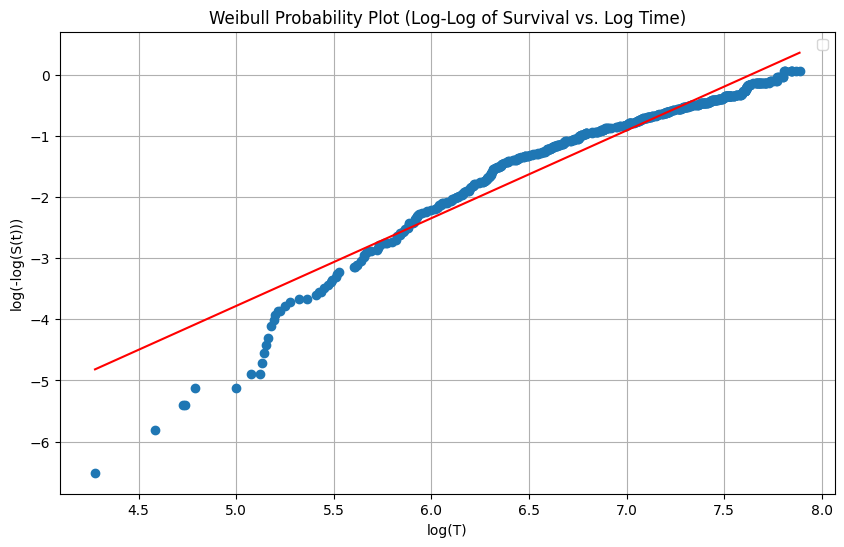

In [6]:
alpha_est, beta_est = estimate_weibull_params(data)

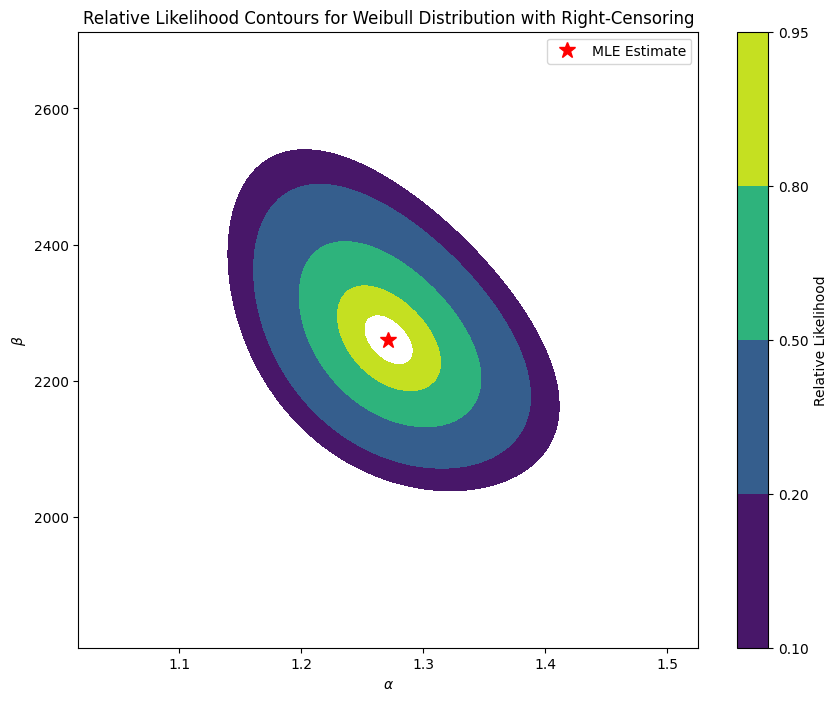

Estimated alpha: 1.2714194932915481
Estimated beta: 2260.4586507900854


In [7]:
# Load data
data = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')  # Replace with your file path

# Extract survival times and censoring indicators
survival_times = data['time'].values
censored = data['status'].values  # Assuming 1 for event and 0 for censoring

# Step 1: Initial estimates based on quantiles
# Estimate of beta
beta_initial = np.quantile(survival_times, 1 - np.exp(-1))

# Estimate of alpha
median_y = np.median(survival_times)
alpha_initial = np.log(np.log(2)) / np.log(median_y / beta_initial)

# Define the log-likelihood function for the Weibull distribution with right-censoring
def weibull_log_likelihood(params, times, censored):
    alpha, beta = params
    term1 = censored * (np.log(alpha) - alpha * np.log(beta) + (alpha - 1) * np.log(times))
    term2 = -((times / beta) ** alpha)
    log_likelihood = np.sum(term1 + term2)
    return -log_likelihood  # Return negative for minimization

# Step 2: Maximize the log-likelihood function to find the best alpha and beta
initial_params = [alpha_initial, beta_initial]
result = minimize(weibull_log_likelihood, initial_params, args=(survival_times, censored),
                  method='L-BFGS-B', bounds=[(0.01, None), (0.01, None)])

# Extract optimized alpha and beta values
alpha_mle, beta_mle = result.x

# Step 3: Generate a grid of alpha and beta values around the MLE estimates for contour plot
alpha_range = np.linspace(alpha_mle * 0.8, alpha_mle * 1.2, 100)
beta_range = np.linspace(beta_mle * 0.8, beta_mle * 1.2, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)

# Calculate relative likelihood values for each pair in the grid
log_likelihood_values = np.zeros_like(alpha_grid)

for i in range(alpha_grid.shape[0]):
    for j in range(alpha_grid.shape[1]):
        log_likelihood_values[i, j] = -weibull_log_likelihood(
            [alpha_grid[i, j], beta_grid[i, j]], survival_times, censored
        )

# Step 4: Convert log-likelihood to relative likelihood
max_log_likelihood = np.max(log_likelihood_values)
relative_likelihood_values = np.exp(log_likelihood_values - max_log_likelihood)

# Step 5: Plot the relative likelihood contour map
plt.figure(figsize=(10, 8))
contour = plt.contourf(alpha_grid, beta_grid, relative_likelihood_values, levels=[0.1, 0.2, 0.5, 0.8, 0.95], cmap='viridis')
plt.colorbar(contour, label='Relative Likelihood')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Relative Likelihood Contours for Weibull Distribution with Right-Censoring')
plt.plot(alpha_mle, beta_mle, 'r*', markersize=12, label='MLE Estimate')
plt.legend()
plt.show()

print(f"Estimated alpha: {alpha_mle}")
print(f"Estimated beta: {beta_mle}")


In [ ]:
# Fit the Kaplan-Meier estimator to the data
kmf = KaplanMeierFitter()
kmf.fit(data['time'], event_observed=data['status'])

# Fit the Weibull distribution to data with estimated alpha and beta
def weibull_cdf(t, alpha, beta):
    return 1 - np.exp(-(t / beta) ** alpha)

# Generate data points for plotting the fitted Weibull survival curve
time_range = np.linspace(0, max(survival_times), 500)
survival_curve = 1 - weibull_cdf(time_range, alpha_mle, beta_mle)

# Plot the Kaplan-Meier estimator and the fitted Weibull survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.plot(time_range, survival_curve, 'r-', label=f'Fitted Weibull (alpha={alpha_mle:.2f}, beta={beta_mle:.2f})')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Weibull Fitting to Survival Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from lifelines import WeibullFitter
wbf = WeibullFitter().fit(data['time'], data['status'], label='WeibullFitter')
wbf.print_summary()

## Add some Bayesian flour

In [ ]:
ALPHA = 0.05 # Significance level
TRAIN = True # Train the Bayesian model? Training it is taking too much time

In [ ]:
# Weibull log-survivor function
def WeibullLogSurvivor(t, alpha, beta):
    return -((t/beta)**alpha)

# Weibull survivor function
def WeibullSurvivor(t, alpha, beta):
    return np.exp(WeibullLogSurvivor(t, alpha, beta))

# Time quantile
def TimeQuantile(p, alpha, beta):
    return beta * (-np.log(1-p))**(1/alpha)

In [ ]:
DatOriginal = data.sort_values("status").reset_index(drop=True)

DatTraining = DatOriginal.iloc[:-75] 
DatTesting = DatOriginal.iloc[-75:]

In [ ]:
import pytensor.tensor as pt

y = DatTraining["time"].values
cens = (DatTraining["status"]==0).values

with pm.Model() as WeibullBayesian:
    MuBeta = pm.Normal("MuBeta", 0, 1)
    MuAlpha = pm.Normal("MuAlpha", 0, 1)

    # Weibull parameters
    Alpha = pm.Deterministic("Alpha", pt.exp(MuAlpha))
    Beta = pm.Deterministic("Beta", pt.exp(MuBeta))

    # Time quantile
    MedianTime = pm.Deterministic("MedianTime", TimeQuantile(0.5, Alpha, Beta))

    # Log-likelihood
    Logdensity = pm.Weibull("TimesObserved", Alpha, Beta, observed=y[~cens])
    Logsurvivor = pm.Potential("TimesCensored", WeibullLogSurvivor(y[cens], Alpha, Beta))

In [ ]:
pm.model_to_graphviz(WeibullBayesian)

In [ ]:
if TRAIN:
    with WeibullBayesian:
        TraceWeibull = pm.sample(draws=500, tune=500, target_accept=0.95)

In [ ]:
if TRAIN:
    TraceWeibull.posterior.to_netcdf("Weibull.h5", engine="scipy")

In [ ]:
if not TRAIN:
    TraceWeibull = open_dataset("Weibull.h5", engine="scipy")

In [ ]:
Summary = az.summary(TraceWeibull, kind="stats", stat_focus="median", hdi_prob=1-ALPHA)
Summary

In [ ]:
az.plot_pair(TraceWeibull, var_names=["Alpha", "Beta"], kind="kde")

In [ ]:
az.plot_posterior(TraceWeibull, var_names="MedianTime", point_estimate="median", hdi_prob=1-ALPHA)

In [ ]:
t_vect = kmf.event_table.index.values

In [ ]:
if TRAIN:
    Aux = TraceWeibull.posterior
else:
    Aux = TraceWeibull

for t in t_vect:
    if t==t_vect[0]:
        Survivor = az.summary(
            WeibullSurvivor(
                t,
                Aux["Alpha"],
                Aux["Beta"]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        Survivor = pd.concat([
            Survivor,
            az.summary(
                WeibullSurvivor(
                    t,
                    Aux["Alpha"],
                    Aux["Beta"]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])
        
Survivor['time'] = t_vect

In [ ]:
kmf.fit(DatTraining['time'], DatTraining['status'])

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

ax.plot(
    Survivor["time"],
    Survivor["mean"],
    color='rebeccapurple',
    label="Weibull_estimate"
)
ax.fill_between(
    Survivor["time"],
    Survivor["hdi_"+str((ALPHA/2)*100)+"%"],
    Survivor["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color="rebeccapurple"
)

kmf.plot_survival_function(color=mpl.colormaps['tab10'].colors[1])

#ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)

In [ ]:
from lifelines.utils import concordance_index

# Get posterior samples from InferenceData (TraceWeibull)
median_samples = TraceWeibull.posterior["MedianTime"].values  # shape: (chain, draw)

# Compute posterior mean of median survival time
median_predicted = median_samples.mean()

# Apply to all test points
median_predicted_array = np.full_like(DatTesting["time"], median_predicted)

# Compute concordance index
c_index = concordance_index(DatTesting["time"], median_predicted_array)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make an array with same prediction for all
median_predicted_array = np.full_like(DatTesting["time"], fill_value=median_predicted)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(DatTesting["time"], median_predicted_array))

In [ ]:
print("Here is the result from Weibull Model")
print(f"Concordance Index: {c_index:.3f}")
print(f"RMSE: {rmse:.2f}")